In [130]:
import librosa.display
import IPython.display as ipd

# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from PIL import Image
import pathlib

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Normalization
from sklearn import preprocessing 

import warnings
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(43)
file_path = '.\TUT-acoustic-scenes-2017-development.meta\TUT-acoustic-scenes-2017-development\evaluation_setup'
fold1 = os.listdir(file_path)

In [300]:
train = os.path.join(file_path,fold1[2])
fold1_filename_train = []
fold1_label_train = []
with open(train, 'r') as f:
    data = f.readlines()  #data reading line by line
    for line in data:
        record = line.split()        #split the filename and label
        fold1_filename_train.append(record[0][6:])
        fold1_label_train.append(record[1])
print('fold 1 has {} sounds to train'.format(len(fold1_filename_train)))


fold 1 has 3510 sounds to train


Because training set is too large, so we can take out some songs for testing our method

In [301]:
# audio = []
# for root,dirnames,filenames in os.walk('./'):
#     for filename in filenames:
#         f = os.path.join(root, filename)
#         if f.endswith('.wav'):
#             audio.append(f)

In [302]:
audio_train = []

indices = np.arange(len(fold1_filename_train))
np.random.shuffle(indices)
n_sound = len(fold1_filename_train)  # select some data to have a try, otherwise we consider the whole data set
indices = indices[:n_sound]
fold1_filename_train = np.array(fold1_filename_train)[indices]
fold1_label_train = np.array(fold1_label_train)[indices]

for root,dirnames,filenames in os.walk('./'):
    for filename in filenames:
         if filename in fold1_filename_train:
            f = os.path.join(root, filename)
            audio_train.append(f)
print(f'training test has {len(audio_train)} data')
print(f'training test label has {len(fold1_label_train)} records')
classes_train = set(fold1_label_train)  # find the unique elements
n_classes_train = len(classes_train)
print(f'There are {n_classes_train} classes in the training data')

training test has 3510 data
training test label has 3510 records
There are 15 classes in the training data


In [303]:
dictionary = dict(zip(classes_train, list(np.arange(n_classes_test))))  # build the connection between labels and numbers
print('label list :\n')
for item in classes_train:
    print(item, dictionary[item])


label list :

metro_station 0
home 1
beach 2
cafe/restaurant 3
residential_area 4
city_center 5
car 6
forest_path 7
grocery_store 8
office 9
train 10
tram 11
park 12
bus 13
library 14


In [304]:
temp=[]
for label in fold1_label_train:
    temp.append(dictionary[label])
fold1_label_train= temp

It takes a lot of time to calculate the MFCC coefficients of traning set, ***30 min*** to load 3510 sound files

In [231]:
%%time

# MFCC is a matrix who stores the MFCC coefficients of each audio

if os.path.exists('MFCC.npy'):
    MFCC = np.load('MFCC.npy')
else:
    MFCC = np.zeros((n_sound,20,431))
    i = 0
    for song,label in zip(audio,fold1_label_train):
        y, sr = librosa.load(song, mono=True)    # original audio file lasts for 10 seconds
        MFCC[i,:,:]= librosa.feature.mfcc(y=y, sr=sr)    # 20 * 431
        i+=1
    np.save('MFCC.npy',MFCC)

Wall time: 0 ns


In [169]:
print(MFCC.shape)

(3510, 20, 431)


In [329]:
# x and y should be vectors
def dist(x,y,choix):
    x_ = (x-np.mean(x))/np.std(x)
    y_ = (y-np.mean(y))/np.std(y)
    if choix == "euclidian":
        return(np.linalg.norm(x_-y_))
    elif choix=="cosine":
        return(1- np.vdot(x_,y_)/np.linalg.norm(x_)/np.linalg.norm(y_))
    
# x and y are feature matrix, the function will calculate the temporal mean MFCC coefficients
def dist_moy(x,y,choix):
    """x et y sont des matrices de MFCC. On calcule la distance entre x et y en faisant la 
    moyenne de chaque dans les matrices puis on regarde la distance entre les deux vecteurs de moyennes."""
    
    xbarre = np.mean(x,axis=1)
    ybarre = np.mean(y,axis=1)
    output = dist(xbarre,ybarre,choix)
    return(output)

In [337]:
# def dist_moy(x,y,choix):
#     """x et y sont des matrices de MFCC. On calcule la distance entre x et y en faisant la 
#     moyenne de chaque dans les matrices puis on regarde la distance entre les deux vecteurs de moyennes."""
    
#     xbarre = np.mean(x,axis=1)
#     ybarre = np.mean(y,axis=1)
    
#     return(dist(xbarre,ybarre,choix))
# dist_moy(data_train_norm[0],data_test_norm[0],'euclidian')
# dist_moy(data_test_norm[0],data_test_norm[1],'euclidian')

1.108545931621443

In [338]:
# x = data_train_norm[0]
# y = data_test_norm[0]
# xbarre = np.mean(x,axis=1)
# ybarre = np.mean(y,axis=1)
# dist(xbarre,ybarre,'cosine')

0.03233879164511755

In [243]:
# Normalization on each segment of MFCC matrix
N_train = len(audio_train)
data_train = MFCC[:,1:,:]   # eliminate the first MFCC coefficient which indicates the energy of each segment
data_train_norm = np.zeros(np.shape(data_train))
for i in range(N_train):
    data_ = data_train[i,:,:]
    data_train_norm[i,:,:] = (data_-np.mean(data_,axis=0))/np.std(data_,axis=0)
print('training data format: ',data_train_norm.shape)

training data format:  (3510, 19, 431)


In [232]:
%%time
if os.path.exists('mat_dist_moy.npy'):
    mat_dist_moy = np.load('mat_dist_moy.npy')
else:
    mat_dist_moy = np.zeros((N_train,N_train))  # calculate the distance among all 3510 files
    for i in range(N_train):
        for j in range(i,N_train):
            mat_dist_moy[i,j] = dist_moy(data_train_norm[i],data_train_norm[j],'euclidian')
            mat_dist_moy[j,i] = mat_dist_moy[i,j]
    # 20 min to calculate the disrtance
    np.save('mat_dist_moy.npy', mat_dist_moy)

Wall time: 1.24 s


p@5 MFCC normalisés :  [0. 0. 0. ... 0. 0. 0.]


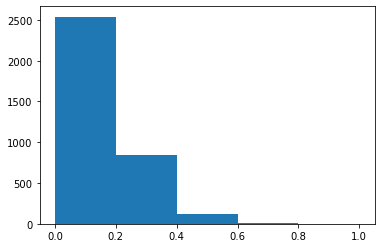

In [218]:
def p_at_k(mat_dist,k,labels):
    N_train = mat_dist.shape[0]
    p5 = np.zeros(N_train)
    labels = np.array(labels)
    for i in range(N_train):
        dist = mat_dist[i,:]
        distsort = np.argsort(np.ravel(dist)) # from small to big

        p5[i] = np.sum([labels[distsort[i]]==labels[i] for i in range(1,k+1)])/k
    return p5

K  =  5  # precision @ K / top K metric
precision = p_at_k(mat_dist_moy,K ,fold1_label_train)
print('p@5 MFCC normalisés : ',precision)
plt.hist(precision, np.arange(K+1)/K)
plt.show()

In [305]:
test = os.path.join(file_path,fold1[0])
fold1_filename_test = []
fold1_label_test = []

with open(test, 'r') as f:
    data = f.readlines()  #data reading line by line
 
    for line in data:
        record = line.split()        #split the filename and label
        fold1_filename_test.append(record[0][6:])
        fold1_label_test.append(record[1])
print('fold 1 has {} documents to test'.format(len(fold1_filename_test)))


fold 1 has 1170 documents to test


In [306]:
audio_test = []

for root,dirnames,filenames in os.walk('./'):
    for filename in filenames:
         if filename in fold1_filename_test:
            f = os.path.join(root, filename)
            audio_test.append(f)

print(f'Test set has {len(audio_test)} records')
classes_test = set(fold1_label_test)
n_classes_test = len(classes_test)
print(f'There are {n_classes_test} classes in the test set')

Test set has 1170 records
There are 15 classes in the test set


In [307]:
temp=[]
for label in fold1_label_test:
    temp.append(dictionary[label])
fold1_label_test= temp

It takes a lot of time to calculate the MFCC coefficients of test set, about 11m 7s to finish the calculation.

In [308]:
%%time
# M_test is a matrix who stores the MFCC infomation about each test audio

if os.path.exists('M_test.npy'):
    M_test = np.load('M_test.npy')
else:
    M_test = np.zeros((len(audio_test),20,431))
    i = 0
    for song in audio_test:
        y, sr = librosa.load(song, mono=True) 
        M_test[i,:,:] = librosa.feature.mfcc(y=y, sr=sr)
        i+=1 
    np.save('M_test.npy',M_test)   

Wall time: 1.26 s


In [309]:
# Normalization on each segment of MFCC matrix

N_test = len(audio_test)
data_test = M_test[:,1:,:]  # eliminate the first MFCC coefficient which indicates the energy of each segment
data_test_norm = np.zeros(np.shape(data_test))

for i in range(N_test):
    data_ = data_test[i,:,:]
    data_test_norm[i,:,:] = (data_-np.mean(data_,axis=0))/np.std(data_,axis=0)
print('test data format: ',data_test_norm.shape)

test data format:  (1170, 19, 431)


In [310]:
print(data_test_norm.shape)
print(data_train_norm.shape)
print(len(fold1_label_train))
print(len(fold1_label_test))

(1170, 19, 431)
(3510, 19, 431)
3510
1170


In [347]:
%%time

if os.path.exists('dist_moy_cross.npy'):
    mat_dist_moy = np.load('dist_moy_cross.npy')

else:
    dist_moy_cross = np.zeros((N_train,N_test))  # calculate the distance between any test file and any train file
    
    for i in range(N_train):
        for j in range(N_test):
            dist_moy_cross[i,j] = dist_moy(data_train_norm[i],data_test_norm[j],'euclidian')   # 15min 18s
    np.save('dist_moy_cross.npy', dist_moy_cross)

Wall time: 36 ms


Predict the label according to the distance between any test audio to the train data

In [355]:
fold1_label_train = np.array(fold1_label_train)
label_pred = np.zeros(N_test)
for i in range(N_test):
    dist = dist_moy_cross[:,i]
    distsort = np.argsort(dist)  # from small to big
    label_pred[i] = fold1_label_train[distsort[1]]  # better to choose the label with the maximum likelihood among the K nearest.


In [357]:
print(label_pred)

[14.  4.  1. ... 12.  8.  4.]
